In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate, Reshape, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from code.modelhelper import *

c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dty

In [2]:
NCLASS = 2
BATCH_SIZE = 150
EPOCHS = 300

In [3]:
m1 = load_model("models/dl/m1_630_nadam.h5")
m2 = load_model("models/dl/m2.h5")
m3 = load_model("models/dl/m3.h5")

W0828 18:18:22.905227  7364 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
x_feat = np.load("data/xy/x_feat_630.npy")
x_char = np.load("data/xy/x_char_onehot_45_15.npz")["arr_0"]
x_word = np.load("data/xy/x_word_45_15.npy")
y = np.load("data/xy/y_onehot_45_15.npy")

In [5]:
xf_train, xf_test, y_train, y_test = train_test_split(
    x_feat,
    y,
    test_size=0.2,
    random_state=11
)

xc_train, xc_test, y_train, y_test = train_test_split(
    x_char,
    y,
    test_size=0.2,
    random_state=11
)

xw_train, xw_test, y_train, y_test = train_test_split(
    x_word,
    y,
    test_size=0.2,
    random_state=11
)

In [6]:
for layer in m1.layers:
    layer.trainable = False
    
for layer in m2.layers:
    layer.trainable = False
    
for layer in m3.layers:
    layer.trainable = False

In [7]:
m1.summary()

W0828 18:19:04.655184  7364 training.py:2055] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_input (InputLayer)        [(None, 630)]             0         
_________________________________________________________________
m1_dense1 (Dense)            (None, 50)                31550     
_________________________________________________________________
m1_dense2 (Dense)            (None, 100)               5100      
_________________________________________________________________
m1_dense3 (Dense)            (None, 150)               15150     
_________________________________________________________________
m1_dense4 (Dense)            (None, 200)               30200     
_________________________________________________________________
m1_dropout1 (Dropout)        (None, 200)               0         
_________________________________________________________________
m1_output (Dense)            (None, 2)                 402 

In [8]:
model_input = concatenate(
    [
        m1.get_layer("m1_dense4").output,
        m2.get_layer("m2_gru_2").output,
        m3.get_layer("m3_lstm").output,
    ]
)

H = Reshape((200+256+32, 1), name="fusion_reshape")(model_input)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_1"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_1")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_2"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_2")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_3"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_3")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_4"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_4")(H)

H = Flatten(name="fusion_flatten")(H)
H = Dense(320, activation='tanh', name="fusion_dense_1")(H)
H = Dense(80, activation='tanh', name="fusion_dense_2")(H)
model_output = Dense(NCLASS, activation='softmax', name="fusion_output")(H)

model = Model(inputs=[m1.input, m2.input, m3.input], outputs=model_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m2_input (InputLayer)           [(None, 13900)]      0                                            
__________________________________________________________________________________________________
m2_reshape (Reshape)            (None, 100, 139, 1)  0           m2_input[0][0]                   
__________________________________________________________________________________________________
m2_timedistributed_1 (TimeDistr (None, 100, 139, 20) 60          m2_reshape[0][0]                 
__________________________________________________________________________________________________
m2_timedistributed_2 (TimeDistr (None, 100, 69, 20)  0           m2_timedistributed_1[0][0]       
______________________________________________________________________________________________

In [9]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

es = EarlyStopping(
    mode="auto",
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    [xf_train, xc_train, xw_train],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=([xf_test, xc_test, xw_test], y_test),
    callbacks=[es]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/300
48000/48000 - 90s - loss: 0.0526 - accuracy: 0.9814 - val_loss: 0.0607 - val_accuracy: 0.9796
Epoch 2/300
48000/48000 - 81s - loss: 0.0419 - accuracy: 0.9867 - val_loss: 0.0578 - val_accuracy: 0.9804
Epoch 3/300
48000/48000 - 81s - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.0579 - val_accuracy: 0.9805
Epoch 4/300
48000/48000 - 83s - loss: 0.0415 - accuracy: 0.9868 - val_loss: 0.0573 - val_accuracy: 0.9814
Epoch 5/300
48000/48000 - 81s - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.0630 - val_accuracy: 0.9807
Epoch 6/300
48000/48000 - 82s - loss: 0.0408 - accuracy: 0.9872 - val_loss: 0.0591 - val_accuracy: 0.9807
Epoch 7/300
48000/48000 - 81s - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0594 - val_accuracy: 0.9812
Epoch 8/300
48000/48000 - 82s - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0618 - val_accuracy: 0.9796
Epoch 9/300
48000/48000 - 81s - loss: 0.0403 - accuracy: 0.9873 - val_loss: 0.0606 - val_accuracy: 0.9

In [10]:
score = model.evaluate([xf_test, xc_test, xw_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred_model = model.predict([xf_test, xc_test, xw_test])
y_pred = to_bin(y_pred_model)
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.05728243071523805
Test accuracy: 0.98141664
Test recall: 0.9509969584319027
[[8963   78]
 [ 145 2814]]


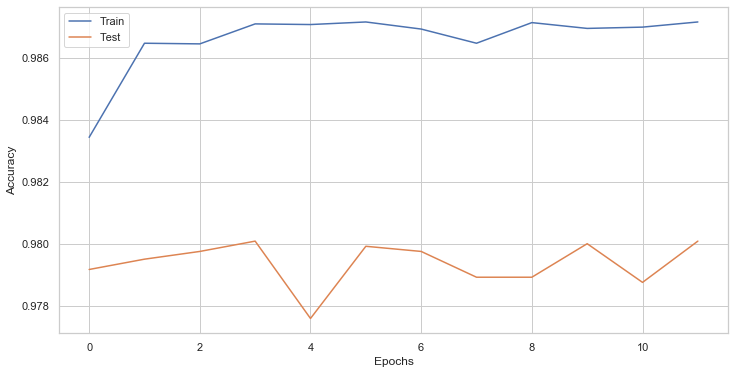

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [11]:
model.save("models/dl/fusion.h5")